In [15]:
import numpy as np
import open3d as o3d
import os
import pathlib

from evo.core.trajectory import PosePath3D, PoseTrajectory3D
from evo.tools.file_interface import write_tum_trajectory_file, read_tum_trajectory_file, read_kitti_poses_file
from evo.core.lie_algebra import se3_inverse
from scipy.spatial.transform import Rotation as R
from tools.tum_tools import *
from tools.tum_plots import *
from tools.tum_definitions import *
from tools.tum_definitions import KISS_CONFIG as config
from evo.core.metrics import PoseRelation, Unit

from pykitti.utils import read_calib_file, transform_from_rot_trans

from os import path

root = "/home/julian/projects/thesis/datasets/converted/mdv3_1/mdv3_full_merge"

result_figure_dir = os.path.join("/mnt/c/Users/J-Dau/OneDrive/TUM/04_SS23/02_MA", "05_presentation")

sequence = ""

%matplotlib widget

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


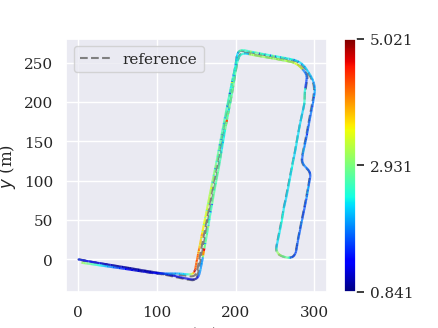

In [16]:


# kiss = read_tum_trajectory_file(path.join(root, sequence, "poses", "raw_kiss.tum"))
kiss = read_tum_trajectory_file(path.join(root, sequence, "poses", "kiss_poses_umeyama.tum"))

gps_file = path.join("data/reference/mdv3_1_reference.tum")
ref = read_tum_trajectory_file(gps_file)
# correct = np.identity(4)
# correct[:3, :3] = R.from_euler('xyz', [0, 0, -80]).as_matrix()

# poses = [np.array([p[0], p[2], -p[1]]) for p in ref.positions_xyz]
# gt = PosePath3D(orientations_quat_wxyz=ref.orientations_quat_wxyz, positions_xyz=poses)
# gt.align_origin(PosePath3D(poses_se3=[correct]))

metric = plot_compare((ref, kiss), print_stats=False, plot_mode='ape', est_name="Optimized", wf=2, hf=0.5)

In [23]:
indices = []
submap_lengths = []
sequence = "presentation_results"
for i in os.listdir(path.join(root, sequence, "submaps")):
    if not i.endswith(".indices"): continue
    
    with open(path.join(root, sequence, "submaps", i)) as f:
        idx_list = [int(e) for e in f.readline().split(', ')]
        submap_lengths.append(len(idx_list))
        indices.extend(idx_list)

global_poses = read_tum_trajectory_file(path.join(root, sequence, "debug_poses", "global_poses_optimized.tum"))
global_poses_orig = read_tum_trajectory_file(path.join(root, sequence, "debug_poses", "global_poses_original.tum"))
        
traj_optim_submaps = read_kitti_poses_file(path.join(root, sequence, "debug_poses", "submap_optimized.kitti"))
traj_no_optim = read_kitti_poses_file(path.join(root, sequence,   "debug_poses", "submap_original.kitti"))

In [24]:
s_indices = sorted(indices)
pcd_path = path.join(root, 'pcd_processed')
files = sorted([f for f in os.listdir(pcd_path) if f.endswith('.pcd')])
files = [files[i] for i in s_indices]


timestamps = [t[0:-6].split('_') for t in files]
timestamps = [float(t[0]) + float(t[1])*1e-9 for t in timestamps]


traj_optim_submaps = PoseTrajectory3D(poses_se3=traj_optim_submaps.poses_se3, timestamps=timestamps)
traj_no_optim = PoseTrajectory3D(poses_se3=traj_no_optim.poses_se3, timestamps=timestamps)
    
    

In [ ]:
# Compare un-optimized vs. optimized global poses
metric = plot_compare((global_poses_orig, global_poses), print_stats=False, plot_mode='ape', est_name="Optimized", wf=2, hf=0.5)

In [ ]:
pair = sync_trajectories(deepcopy(ref), deepcopy(global_poses), 0.1)
metric = plot_compare(pair, print_stats=False, plot_mode='ape', est_name="Optimized", wf=2, hf=0.5)

In [11]:
relative_global_poses = []
for i, pose in enumerate(global_poses.poses_se3):
    if i == 0:
        relative_global_poses.append(pose)
    else:
        relative_global_poses.append(relative_global_poses[-1] * pose)

In [62]:

aligned_submap_poses = []

lower = 0
upper = 0
# for num_poses, trans in zip(submap_lengths, relative_global_poses):
for num_poses, trans in zip(submap_lengths, global_poses.poses_se3):
    
    lower = upper
    upper += num_poses
    
    poses = traj_optim_submaps.poses_se3[lower:upper]
    
    mid_pose = poses[len(poses) // 2]
    
    transform = trans @ se3_inverse(mid_pose)
    
    # print(transform)
    # print(mid_pose)
    # print(mid_pose)
    # break
        
    aligned_submap_poses.extend(transform @ p for p in poses)
    
    lower += num_poses
    
traj_aligned_submaps = PoseTrajectory3D(poses_se3=aligned_submap_poses, timestamps=timestamps)

In [25]:
aligned_submap_poses = []
lower = 0
upper = 0
for num_poses, orig, optim in zip(submap_lengths, global_poses_orig.poses_se3, global_poses.poses_se3):
    lower = upper
    upper += num_poses
    
    poses = traj_optim_submaps.poses_se3[lower:upper]
    transform = optim @ se3_inverse(orig)
    # transform = orig @ se3_inverse(optim)
    aligned_submap_poses.extend(transform @ p for p in poses)
    
    lower += num_poses
traj_aligned_submaps = PoseTrajectory3D(poses_se3=aligned_submap_poses, timestamps=timestamps)

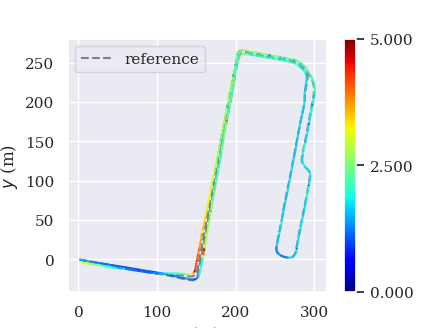

In [28]:
pair = sync_trajectories(deepcopy(ref), traj_no_optim, max_diff=0.01)
metric = plot_compare(pair, print_stats=False, plot_mode='ape', est_name="Optimized", pose_relation=PoseRelation.translation_part, wf=2, hf=2)
plt.savefig(path.join(result_figure_dir, f"traj_no_optim.pdf"), format="pdf", bbox_inches="tight")

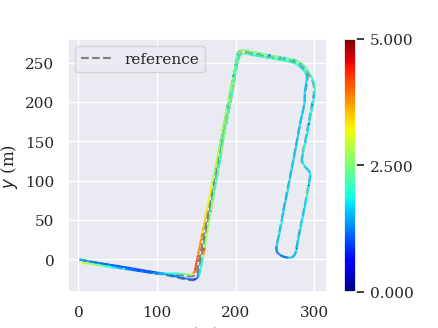

In [29]:
pair = sync_trajectories(deepcopy(ref), traj_optim_submaps, max_diff=0.01)
metric = plot_compare(pair, print_stats=False, plot_mode='ape', est_name="Optimized", pose_relation=PoseRelation.translation_part, wf=2, hf=2)
plt.savefig(path.join(result_figure_dir, f"traj_local_optim.pdf"), format="pdf", bbox_inches="tight")

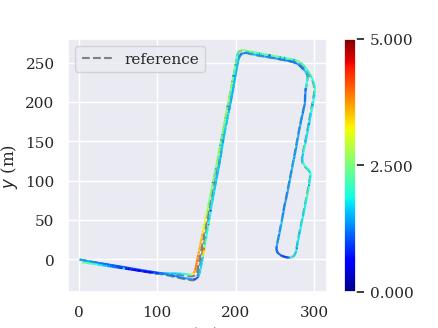

In [30]:
pair = sync_trajectories(deepcopy(ref), traj_aligned_submaps, max_diff=0.01)
metric = plot_compare(pair, print_stats=False, plot_mode='ape', est_name="Optimized", pose_relation=PoseRelation.translation_part, wf=2, hf=2)
plt.savefig(path.join(result_figure_dir, f"traj_global_optim.pdf"), format="pdf", bbox_inches="tight")

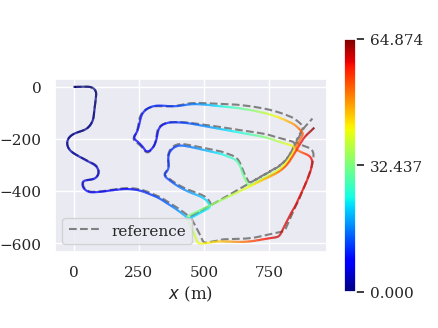

In [10]:
metric = plot_compare((ref_aligned, kiss_aligned), print_stats=False, plot_mode='ape', est_name="Optimized", wf=2, hf=0.5)